# <h1 align="center">🤗<font color="yellow">SetFit: Efficient Few-Shot Learning Without Prompts</font>🤗</h1>

<font color="yellow">Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro</font>

<font color="pink">O SetFit é significativamente mais eficiente em termos de amostragem e robusto a ruído do que o `Fine-tuning` padrão.</font>

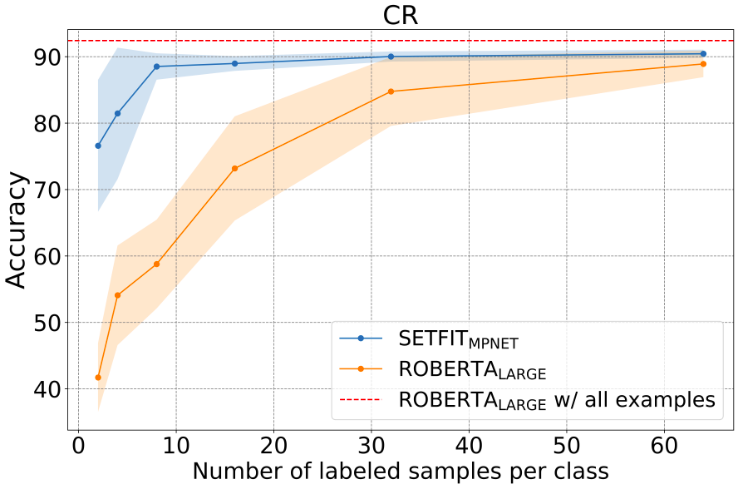

O aprendizado de poucos tiros (`Few-Shot Learning`) com modelos de linguagem pré-treinados surgiu como uma solução promissora para o pesadelo de todo `cientista de dados`: lidar com dados que têm poucos ou nenhum rótulo 😱.


Juntamente com nossos parceiros de pesquisa da [Intel Labs](https://www.intel.com/content/www/us/en/research/overview.html) e do [UKP Lab](https://www.informatik.tu-darmstadt.de/ukp/ukp_home/index.en.jsp), a `Hugging Face` tem o prazer de apresentar o `SetFit`: uma Framework eficiente para o ajuste fino de [sentence Transformers](https://sbert.net/). O SetFit alcança alta accuracy com poucos dados rotulados - `por exemplo`, com apenas `8 exemplos rotulados` por classe no conjunto de dados de `sentimento do Customer Reviews` (CR), o SetFit é competitivo com o ajuste fino do `RoBERTa Large` no conjunto de treinamento completo de `3k exemplos` 🤯!

Comparado a outros métodos de aprendizado de poucos tiros, o `SetFit` possui vários features exclusivos:


🗣 `Sem Prompts ou verbalizadores:` as técnicas atuais para ajuste fino de poucos tiros exigem `prompts` ou `verbalizadores artesanais` para converter exemplos em um formato adequado para o modelo de linguagem subjacente. O `SetFit` dispensa totalmente os `prompts`, gerando `Embeddings` avançados diretamente de um pequeno número de exemplos de texto rotulados.


🏎 `Rápido para treinar:` SetFit não requer modelos de grande escala como `T0` ou `GPT-3` para alcançar alta accuracy. Como resultado, normalmente é uma ordem de grandeza (ou mais) mais rápida para treinar e executar a inferência.


🌎 `Suporte multilíngue:` o SetFit pode ser usado com qualquer `Sentence Transformers` no Hub, o que significa que você pode classificar o texto em vários idiomas simplesmente fazendo fine-tuning a um ponto de verificação multilíngue.



Para obter mais detalhes, confira o [paper](https://arxiv.org/abs/2209.11055), [data](https://huggingface.co/SetFit) e [code](https://github.com/huggingface/setfit). Nesta postagem do blog, explicaremos como o SetFit funciona e como treinar seus próprios modelos. Vamos mergulhar!

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# <font color="red">Treinando nosso próprio modelo</font>

<font color="orange">Para tornar o `SetFit` acessível à comunidade, criamos uma pequena [setfit biblioteca](https://github.com/huggingface/setfit) que permite treinar seus próprios modelos com apenas algumas linhas de código. A primeira coisa a fazer é instalá-lo executando o seguinte comando:</font>

In [ ]:
%pip install setfit


Em seguida, importamos `SetFitModel` e `SetFitTrainer`, duas classes principais que agilizam o processo de treinamento do SetFit:

In [1]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer


/home/eddygiusepe/1_Eddy_Giusepe/4_SetFit_Few-Shot_Learning/SetFit_Efficient_Few-Shot_Learning_without_Prompts/venv_SetFit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<font color="orange">Agora, vamos baixar um conjunto de dados de `classificação de texto do Hugging Face Hub`. Usaremos o conjunto de dados [SentEval-CR](https://huggingface.co/datasets/SetFit/SentEval-CR), que é um conjunto de dados de `avaliações de clientes`:</font>

In [2]:
dataset = load_dataset("SetFit/SentEval-CR")

Found cached dataset json (/home/eddygiusepe/.cache/huggingface/datasets/SetFit___json/SetFit--SentEval-CR-c9aa0d3185fe82a0/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)
100%|██████████| 2/2 [00:00<00:00, 305.27it/s]


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 3012
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 753
    })
})

In [4]:
dataset['train']

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 3012
})

In [5]:
dataset['train'][0]

{'text': "many of our disney movies do n 't play on this dvd player .",
 'label': 0,
 'label_text': 'negative'}

In [6]:
# Visualizamos com pandas:
import pandas as pd


train_eddy = pd.DataFrame(dataset['train'])
train_eddy.head()


,text,label,label_text
0,many of our disney movies do n 't play on this...,0,negative
1,player has a problem with dual-layer dvd 's su...,0,negative
2,i know the saying is `` you get what you pay f...,0,negative
3,will never purchase apex again .,0,negative
4,customer service and technical support are ove...,0,negative


In [7]:
train_eddy.shape

(3012, 3)

In [8]:
train_eddy['label_text'].unique()

array(['negative', 'positive'], dtype=object)

<font color="orange">Para simular um cenário do mundo real com apenas alguns exemplos rotulados, vamos amostrar `8` exemplos por classe do conjunto de `treinamento`:</font>

In [9]:
# Selecione N exemplos por classe (8 neste caso)
train_ds = dataset["train"].shuffle(seed=42).select(range(8 * 2))
test_ds = dataset["test"]


Loading cached shuffled indices for dataset at /home/eddygiusepe/.cache/huggingface/datasets/SetFit___json/SetFit--SentEval-CR-c9aa0d3185fe82a0/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e/cache-a855b9357c959754.arrow


In [10]:
train_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16
})

In [11]:
test_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 753
})

<font color="orange">Agora que temos um conjunto de dados, a próxima etapa é carregar um `Modelo pré-treinado do Sentence Transformer do Hub` e instanciar um `SetFitTrainer`. Aqui usamos o modelo [paraphrase-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2), que encontramos para dar ótimos resultados em muitos conjuntos de dados:</font>

In [12]:
# Carregar Modelo SetFit do Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    loss_class=CosineSimilarityLoss,
    batch_size=8,
    num_iterations=20, # Número de pares de texto a serem gerados para APRENDIZADO CONTRASTIVO
    num_epochs=1 # Número de épocas a serem usadas para APRENDIZADO CONTRASTIVO
)



/home/eddygiusepe/1_Eddy_Giusepe/4_SetFit_Few-Shot_Learning/SetFit_Efficient_Few-Shot_Learning_without_Prompts/venv_SetFit/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


<font color="orange">A última etapa é treinar e avaliar o modelo:</font>

In [ ]:
# Treinamos
trainer.train()


In [ ]:
# Avaliação
metrics = trainer.evaluate()
metrics


E é isso - agora você treinou seu `primeiro modelo SetFit`! Lembre-se de enviar seu modelo treinado para o Hub :)

In [ ]:
# Push do Modelo para o Hub
# Certifique-se de estar logado com huggingface-cli -->  login primeiro

#trainer.push_to_hub("my-awesome-setfit-model")
